In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        return x

# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
# Load MNIST dataset
mnist_transform = transforms.Compose([transforms.ToTensor()])

mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)


# Instantiate the CNN model and move it to the device
cnn_model = CNN().to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)


In [11]:
num_epochs = 10
train_loss_list, test_loss_list = [], []

for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss / len(train_loader))

    cnn_model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss_list.append(test_loss / len(test_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}')



Epoch [1/10], Train Loss: 1.6759, Test Loss: 1.5350
Epoch [2/10], Train Loss: 1.5202, Test Loss: 1.5280
Epoch [3/10], Train Loss: 1.4983, Test Loss: 1.5121
Epoch [4/10], Train Loss: 1.4882, Test Loss: 1.5129
Epoch [5/10], Train Loss: 1.4797, Test Loss: 1.5042
Epoch [6/10], Train Loss: 1.4739, Test Loss: 1.5097
Epoch [7/10], Train Loss: 1.4694, Test Loss: 1.5121
Epoch [8/10], Train Loss: 1.4666, Test Loss: 1.5071
Epoch [9/10], Train Loss: 1.4627, Test Loss: 1.5090
Epoch [10/10], Train Loss: 1.4615, Test Loss: 1.5008


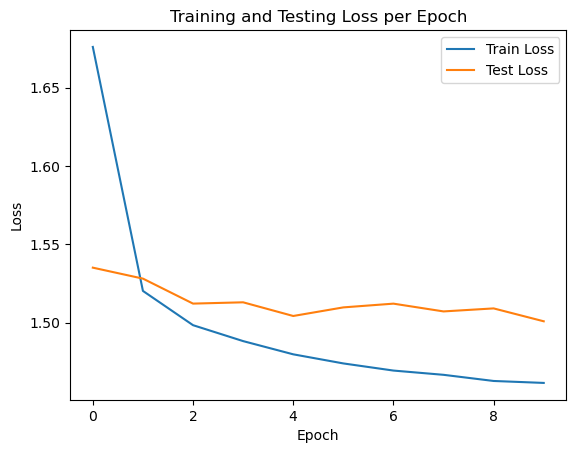

In [12]:
import matplotlib.pyplot as plt

# Plotting the training and testing loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

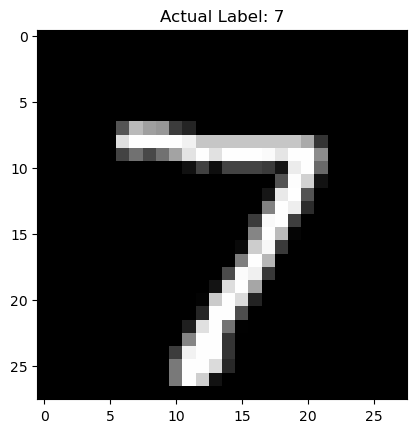

In [13]:
# Get a single image and label from the test set
images, labels = next(iter(test_loader))
image, label = images[0], labels[0]

# Preview the image
plt.imshow(image.squeeze(), cmap='gray')  # Squeeze removes the channel dimension to display the image
plt.title(f'Actual Label: {label.item()}')
plt.show()

In [14]:
cnn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Move the image to the device and add a batch dimension
    image = image.to(device).unsqueeze(0)
    
    output = cnn_model(image)
    _, predicted = torch.max(output, 1)
    prediction = predicted.item()

print(f'Predicted class: {prediction}')

Predicted class: 7


In [15]:
# Assuming you have a DataLoader named 'test_loader' for your test dataset
# and a model 'cnn_model' already trained and transferred to the correct device

cnn_model.eval()  # Set the model to evaluation mode
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted_labels.extend(predicted.view_as(labels))
        all_true_labels.extend(labels)

# Convert the lists of tensors to single tensors
all_predicted_labels = torch.stack(all_predicted_labels)
all_true_labels = torch.stack(all_true_labels)

# Calculate the accuracy
accuracy = (all_predicted_labels == all_true_labels).sum().item() / len(all_true_labels)
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')


Accuracy of the model on the test images: 78.74%


In [16]:
# write a confusion matrix for what digit are being confused with what
for i in range(10):
    print(f'Class {i} accuracy: {((all_predicted_labels == i) & (all_true_labels == i)).sum().item() / (all_true_labels == i).sum().item() * 100:.2f}%')

Class 0 accuracy: 96.22%
Class 1 accuracy: 99.74%
Class 2 accuracy: 0.00%
Class 3 accuracy: 99.50%
Class 4 accuracy: 99.69%
Class 5 accuracy: 98.99%
Class 6 accuracy: 99.27%
Class 7 accuracy: 99.22%
Class 8 accuracy: 98.67%
Class 9 accuracy: 0.00%


In [20]:
confusion_matrix = torch.zeros(10, 10, dtype=torch.float)
for i in range(len(all_true_labels)):
    confusion_matrix[all_true_labels[i], all_predicted_labels[i]] += 1
    
print(confusion_matrix)

tensor([[9.4300e+02, 1.0000e+00, 0.0000e+00, 2.0000e+00, 5.0000e+00, 7.0000e+00,
         1.2000e+01, 1.0000e+00, 9.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1320e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.4100e+02, 2.1000e+01, 0.0000e+00, 2.0000e+01, 6.0000e+00, 1.0000e+00,
         7.0000e+00, 2.1000e+01, 1.5000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0050e+03, 0.0000e+00, 5.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 9.7900e+02, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00, 0.0000e+00, 8.8300e+02,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
         9.5100e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.0000

In [21]:
# turn the confusion matrix to percentage as float
for i in range(10):
    confusion_matrix[i] = confusion_matrix[i] / confusion_matrix[i].sum() * 100
print(confusion_matrix)

tensor([[9.6224e+01, 1.0204e-01, 0.0000e+00, 2.0408e-01, 5.1020e-01, 7.1429e-01,
         1.2245e+00, 1.0204e-01, 9.1837e-01, 0.0000e+00],
        [0.0000e+00, 9.9736e+01, 0.0000e+00, 8.8106e-02, 0.0000e+00, 8.8106e-02,
         0.0000e+00, 8.8106e-02, 0.0000e+00, 0.0000e+00],
        [9.1182e+01, 2.0349e+00, 0.0000e+00, 1.9380e+00, 5.8140e-01, 9.6899e-02,
         6.7829e-01, 2.0349e+00, 1.4535e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9505e+01, 0.0000e+00, 4.9505e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0183e-01, 0.0000e+00, 0.0000e+00, 9.9695e+01, 0.0000e+00,
         0.0000e+00, 1.0183e-01, 1.0183e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8475e-01, 0.0000e+00, 9.8991e+01,
         0.0000e+00, 1.1211e-01, 1.1211e-01, 0.0000e+00],
        [0.0000e+00, 1.0438e-01, 0.0000e+00, 1.0438e-01, 1.0438e-01, 3.1315e-01,
         9.9269e+01, 0.0000e+00, 1.0438e-01, 0.0000e+00],
        [0.0000e+00, 4.8638

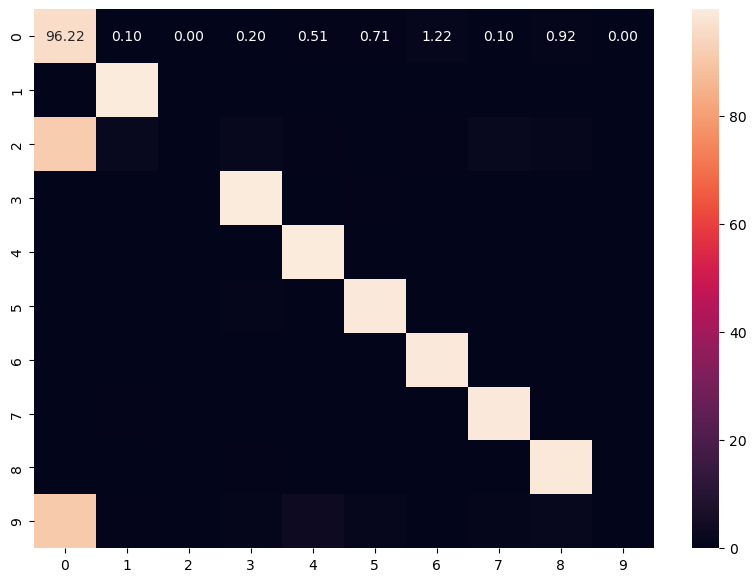

In [22]:
# draw the confusion matrix heatmap
import seaborn as sns
import pandas as pd

df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.show()